so basically i'm gonna copy a bunch of code from [here](https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/blob/main/Deep_Unsupervised_Learning_using_Nonequilibrium_Thermodynamics/diffusion_models.py), run it, read through it and try to figure out how it works, then write each line out step-by-step explaining what it's doing along teh way to show that i actuall understand what's happening

# setup

In [1]:
# my virtual environments are rarely properly connected to jupyter so this fixes that
import sys
import os
current_dir = os.getcwd()  # Get the current working directory
venv_dir = os.path.join(current_dir, 'venv') 
python_version = str(sys.version_info.major) + '.' + str(sys.version_info.minor)
site_packages_path = os.path.join(venv_dir, 'lib', 'python' + python_version, 'site-packages')
sys.path.append(site_packages_path) 

In [2]:
# Importing pytorch
import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np
import math

# imports for the debugging/demonstration setup
import functools
import inspect

import torch.utils.data
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

import random
import time
from tqdm import tqdm

In [3]:
# this function will be used throughout for debugging/demonstration purposes
# using this is way cleaner than cluttering up our code with print statements
def log_io(func):
    @functools.wraps(func)
    def wrapper(self, *args, **kwargs):
        # Check if logging is enabled globally and for the specific function
        if not self.logging_enabled or func.__name__ in self.disabled_logging_functions:
            return func(self, *args, **kwargs)
        #if not self.logging_enabled:
            #return func(self, *args, **kwargs)

        def log_item(item, name, level=0, is_root=False):
            indent = "    " * level
            if isinstance(item, torch.Tensor):
                print(f"{indent}Tensor '{name}' shape: {item.shape}")
            elif isinstance(item, tuple):
                if is_root and level == 0:
                    # Root level tuple, don't print it as a tuple unless it's a "true" tuple
                    for idx, sub_item in enumerate(item):
                        log_item(sub_item, f"{name}[{idx}]", level)
                else:
                    print(f"{indent}Tuple '{name}':")
                    for idx, sub_item in enumerate(item):
                        log_item(sub_item, f"{name}[{idx}]", level + 1)
            elif isinstance(item, int):
                print(f"{indent}Integer '{name}': Value={item}")
            elif isinstance(item, float):
                print(f"{indent}Float '{name}': Value={item}")
            else:
                print(f"{indent}Other-type '{name}': Type={type(item).__name__}, Value={item}")

        print(f"\n{'='*10}Entering {self.__class__.__name__}.{func.__name__}{'='*10}")
        print("Inputs:")
        arg_names = inspect.getfullargspec(func).args[1:]  # Excluding 'self'
        arg_values = args + tuple(kwargs.values())
        for name, value in zip(arg_names, arg_values):
            log_item(value, name)

        result = func(self, *args, **kwargs)
        print("\nOutputs:")
        if isinstance(result, tuple):
            log_item(result, "output", is_root=True)
        else:
            log_item(result, "output")

        print(f"{'='*10}Exiting {self.__class__.__name__}.{func.__name__}{'='*10}")
        return result
    return wrapper

class LoggingModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.logging_enabled = False
        self.disabled_logging_functions = set()

    def enable_logging(self):
        self.logging_enabled = True

    def disable_logging(self):
        self.logging_enabled = False

    def disable_function_logging(self, func_name):
        self.disabled_logging_functions.add(func_name)

    def enable_function_logging(self, func_name):
        self.disabled_logging_functions.discard(func_name)

### most of the following code is from [here](https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/blob/main/Deep_Unsupervised_Learning_using_Nonequilibrium_Thermodynamics/diffusion_models.py)

In [4]:
def sample_batch(size):
    x, _ = make_swiss_roll(size)
    return x[:, [2, 0]] / 10.0 * np.array([1, -1])

# it's not obvious from looking at it but this returns random points from those swirly shapes (pics in link above)
sample_batch(16)

array([[-0.68906001, -0.97656283],
       [ 0.84170368, -1.0238813 ],
       [-0.4575466 , -0.24953185],
       [ 0.00675126,  0.94173671],
       [ 0.50837225,  0.71948385],
       [ 0.79115453,  0.12788849],
       [-1.02976993,  0.29627441],
       [ 0.79089517,  0.06417287],
       [-1.00256097,  0.35964085],
       [-0.1659278 , -0.57692681],
       [ 0.24071496, -1.25270348],
       [ 0.93279184, -0.95374628],
       [-0.87335451, -0.78248138],
       [-0.01027091, -0.62659534],
       [-0.70010047, -0.96718727],
       [-0.78376103, -0.88787775]])

In [5]:
class MLP(LoggingModule):
    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()

        # the first two layers
        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim), nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), )

        # each timestep gets its own unique output set of two layers
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                                         nn.ReLU(), nn.Linear(hidden_dim, data_dim * 2)
                                                         ) for _ in range(N)])

    @log_io
    def forward(self, x, t: int, training=False):
        h = F.dropout(self.network_head(x), p=0.1, training=training)
        return self.network_tail[t](h)

In [6]:
module = MLP()
module.enable_logging()
output = module(x = torch.randn(16,2), t = random.randint(1, 40)) # (batch size, data dimension) -> (batch_size, data dimension * 2) not sure why there's a *2 yet
del module, output


==========Entering MLP.forward==========
Inputs:
Tensor 'x' shape: torch.Size([16, 2])
Integer 't': Value=8

Outputs:
Tensor 'output' shape: torch.Size([16, 4])
==========Exiting MLP.forward==========


# Model

In [6]:
class DiffusionModel(LoggingModule):
    def __init__(self, 
                 model: nn.Module, 
                 n_steps=40, 
                 device='mps' if torch.backends.mps.is_available() else 'cpu'):
        super().__init__()

        self.model = model
        self.device = device

        betas = torch.linspace(-18, 10, n_steps)
        self.beta = torch.sigmoid(betas) * (3e-1 - 1e-5) + 1e-5

        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta

    @log_io
    def forward_process(self, x0, t):
        t = t - 1  # Start indexing at 0
        beta_forward = self.beta[t]
        alpha_forward = self.alpha[t]
        alpha_cum_forward = self.alpha_bar[t]
        xt = x0 * torch.sqrt(alpha_cum_forward) + torch.randn_like(x0) * torch.sqrt(1. - alpha_cum_forward)
        # Retrieved from https://github.com/Sohl-Dickstein/Diffusion-Probabilistic-Models/blob/master/model.py#L203
        mu1_scl = torch.sqrt(alpha_cum_forward / alpha_forward)
        mu2_scl = 1. / torch.sqrt(alpha_forward)
        cov1 = 1. - alpha_cum_forward / alpha_forward
        cov2 = beta_forward / alpha_forward
        lam = 1. / cov1 + 1. / cov2
        mu = (x0 * mu1_scl / cov1 + xt * mu2_scl / cov2) / lam
        sigma = torch.sqrt(1. / lam)
        return mu, sigma, xt

    @log_io
    def reverse(self, xt, t, training=True):
        t = t - 1  # Start indexing at 0
        if t == 0: return None, None, xt
        mu, h = self.model(xt, t, training).chunk(2, dim=1) # so i think this is why the MLP output is data_dim*2. we separete it out into 2 equal sized chunks
        sigma = torch.sqrt(torch.exp(h))
        samples = mu + torch.randn_like(xt) * sigma
        return mu, sigma, samples

    @log_io
    def sample(self, size, device):
        noise = torch.randn((size, 2)).to(device)
        samples = [noise]
        for t in range(self.n_steps):
            _, _, x = self.reverse(samples[-1], self.n_steps - t - 1 + 1, training=False)
            samples.append(x)
        return samples

### demonstrations

In [19]:
module_mlp = MLP()
module = DiffusionModel(module_mlp)
module.enable_logging()
mu, sigma, xt = module.forward_process(x0 = torch.randn(2048,2), t = random.randint(1, 40))
print(mu.shape, sigma.shape, xt.shape)
del module_mlp, module, mu, sigma, xt


==========Entering DiffusionModel.forward_process==========
Inputs:
Tensor 'x0' shape: torch.Size([2048, 2])
Integer 't': Value=5

Outputs:
Tensor 'output[0]' shape: torch.Size([2048, 2])
Tensor 'output[1]' shape: torch.Size([])
Tensor 'output[2]' shape: torch.Size([2048, 2])
==========Exiting DiffusionModel.forward_process==========
torch.Size([2048, 2]) torch.Size([]) torch.Size([2048, 2])


In [20]:
module_mlp = MLP()
module = DiffusionModel(module_mlp)
module.enable_logging()
mu, sigma, samples = module.reverse(xt = torch.randn(2048,2), t = random.randint(1, 40))
print(mu.shape, sigma.shape, samples.shape)
del module_mlp, module, mu, sigma, samples


==========Entering DiffusionModel.reverse==========
Inputs:
Tensor 'xt' shape: torch.Size([2048, 2])
Integer 't': Value=4

Outputs:
Tensor 'output[0]' shape: torch.Size([2048, 2])
Tensor 'output[1]' shape: torch.Size([2048, 2])
Tensor 'output[2]' shape: torch.Size([2048, 2])
==========Exiting DiffusionModel.reverse==========
torch.Size([2048, 2]) torch.Size([2048, 2]) torch.Size([2048, 2])


In [23]:
module_mlp = MLP()
module = DiffusionModel(module_mlp)
module.enable_logging()
samples = module.sample(size=1024, device='cpu')
del module_mlp, module, samples


==========Entering DiffusionModel.sample==========
Inputs:
Integer 'size': Value=1024
Other-type 'device': Type=str, Value=cpu

==========Entering DiffusionModel.reverse==========
Inputs:
Tensor 'xt' shape: torch.Size([1024, 2])
Integer 't': Value=40

Outputs:
Tensor 'output[0]' shape: torch.Size([1024, 2])
Tensor 'output[1]' shape: torch.Size([1024, 2])
Tensor 'output[2]' shape: torch.Size([1024, 2])
==========Exiting DiffusionModel.reverse==========

==========Entering DiffusionModel.reverse==========
Inputs:
Tensor 'xt' shape: torch.Size([1024, 2])
Integer 't': Value=39

Outputs:
Tensor 'output[0]' shape: torch.Size([1024, 2])
Tensor 'output[1]' shape: torch.Size([1024, 2])
Tensor 'output[2]' shape: torch.Size([1024, 2])
==========Exiting DiffusionModel.reverse==========

==========Entering DiffusionModel.reverse==========
Inputs:
Tensor 'xt' shape: torch.Size([1024, 2])
Integer 't': Value=38

Outputs:
Tensor 'output[0]' shape: torch.Size([1024, 2])
Tensor 'output[1]' shape: torch.

# Plot

In [7]:
def plot(model, save=False):
    plt.figure(figsize=(10, 6))
    x0 = sample_batch(5000).astype(np.float32)
    x20 = model.forward_process(torch.from_numpy(x0).to(device), 20)[-1].data.cpu().numpy()
    x40 = model.forward_process(torch.from_numpy(x0).to(device), 40)[-1].data.cpu().numpy()
    data = [x0, x20, x40]
    for i, t in enumerate([0, 20, 39]):
        plt.subplot(2, 3, 1 + i)
        plt.scatter(data[i][:, 0], data[i][:, 1], alpha=.1, s=1)
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        if t == 0: plt.ylabel(r'$q(\mathbf{x}^{(0...T)})$', fontsize=17, rotation=0, labelpad=60)
        if i == 0: plt.title(r'$t=0$', fontsize=17)
        if i == 1: plt.title(r'$t=\frac{T}{2}$', fontsize=17)
        if i == 2: plt.title(r'$t=T$', fontsize=17)

    samples = model.sample(5000, device)
    for i, t in enumerate([0, 20, 40]):
        plt.subplot(2, 3, 4 + i)
        plt.scatter(samples[40 - t][:, 0].data.cpu().numpy(), samples[40 - t][:, 1].data.cpu().numpy(),
                    alpha=.1, s=1, c='r')
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        if t == 0: plt.ylabel(r'$p(\mathbf{x}^{(0...T)})$', fontsize=17, rotation=0, labelpad=60)
    if save: plt.savefig(f"Imgs/diffusion_model.png", bbox_inches='tight')
    plt.show()
    plt.close()

In [8]:
def train(model, optimizer, nb_epochs=150_000, batch_size=64_000):
    training_loss = []
    for _ in tqdm(range(nb_epochs)):
        x0 = torch.from_numpy(sample_batch(batch_size)).float().to(device)
        t = np.random.randint(2, 40 + 1)
        mu_posterior, sigma_posterior, xt = model.forward_process(x0, t)
        mu, sigma, _ = model.reverse(xt, t)

        KL = (torch.log(sigma) - torch.log(sigma_posterior) + (sigma_posterior ** 2 + (mu_posterior - mu) ** 2) / (2 * sigma ** 2) - 0.5)
        loss = KL.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss.append(loss.item())

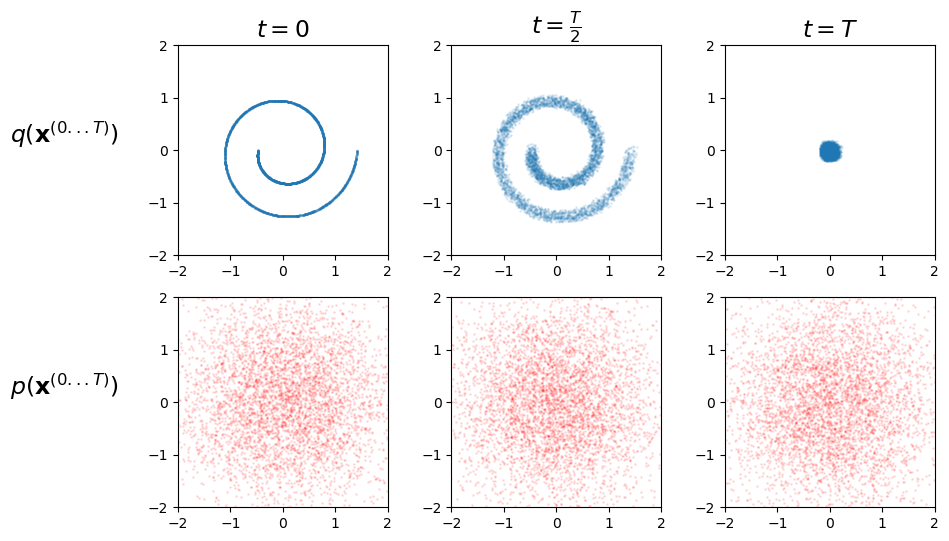

100%|███████████████████████████| 150000/150000 [6:44:56<00:00,  6.17it/s]


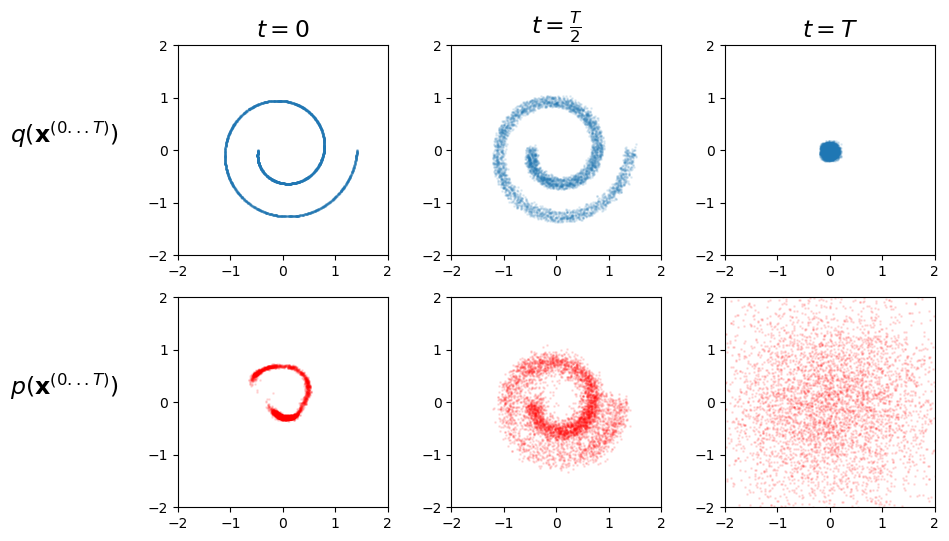

In [9]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
model_mlp = MLP(hidden_dim=128).to(device)
model = DiffusionModel(model_mlp)
plot(model)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=1e-4)
train(model, optimizer, nb_epochs = 150_000, batch_size = 32_000)
plot(model)

# step-by-step walkthrough: training

first we need to define our data. these little spiral shapes from scipy are kinda cool, it really just outputs a series of points along them. so the tensor is just batch size by number of dimensions (2). 

In [19]:
batch_size = 4
x, _ = make_swiss_roll(batch_size)
print(f'x: {x.shape}\n{x}\n')

# apparently we need to reorder them and remove a specific column? i wonder if i could use that column to do a 3D version?
x = x[:, [2, 0]] 
print(f'x: {x.shape}\n{x}\n')
# what's the point of reordering? wouldn't those work just fine in the original order but the image would look different?

# and then scale & make the right column negative
x = x / 10.0 * np.array([1, -1])
print(f'x: {x.shape}\n{x}\n')

x0 = torch.from_numpy(x0)

x: (4, 3)
[[ 0.58840169  9.575105   14.08312407]
 [11.46934406  4.86799116  6.2587484 ]
 [ 9.13316427 18.24711168  9.78663247]
 [-9.35944814 12.278214   -2.48865806]]

x: (4, 2)
[[14.08312407  0.58840169]
 [ 6.2587484  11.46934406]
 [ 9.78663247  9.13316427]
 [-2.48865806 -9.35944814]]

x: (4, 2)
[[ 1.40831241 -0.05884017]
 [ 0.62587484 -1.14693441]
 [ 0.97866325 -0.91331643]
 [-0.24886581  0.93594481]]



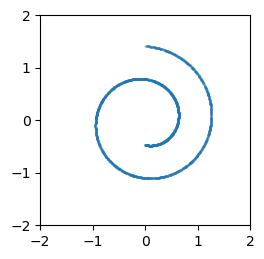

In [38]:
def sample_batch(size):
    x, _ = make_swiss_roll(size)
    return x[:, [0,2]]/10.0#[2, 0]] / 10.0 #* np.array([1, -1])
# so i guess we can do some rearranging if we want

x0 = sample_batch(5000).astype(np.float32)
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.scatter(x0[:, 0], x0[:, 1], alpha=.1, s=1)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.gca().set_aspect('equal')

plt.show()
plt.close()

In [45]:
# randomly choose which timestep we're training on 
t = np.random.randint(2, 40 + 1) # i guess we start at zero bc we're training from step 2 to step 1? why aint we zero indexing?
print(f't: {t}\n')

t: 6



In [54]:
# i insist on zero indexing in all my code
t = np.random.randint(1, 40) # possible values [1,39] brackets mean inclusive
print(f't: {t}\n')

t: 21



betas: tensor([-18.0000, -17.2821, -16.5641, -15.8462, -15.1282, -14.4103, -13.6923,
        -12.9744, -12.2564, -11.5385, -10.8205, -10.1026,  -9.3846,  -8.6667,
         -7.9487,  -7.2308,  -6.5128,  -5.7949,  -5.0769,  -4.3590,  -3.6410,
         -2.9231,  -2.2051,  -1.4872,  -0.7692,  -0.0513,   0.6667,   1.3846,
          2.1026,   2.8205,   3.5385,   4.2564,   4.9744,   5.6923,   6.4103,
          7.1282,   7.8462,   8.5641,   9.2821,  10.0000])

beta: torch.Size([40])
tensor([1.0005e-05, 1.0009e-05, 1.0019e-05, 1.0039e-05, 1.0081e-05, 1.0166e-05,
        1.0339e-05, 1.0696e-05, 1.1426e-05, 1.2924e-05, 1.5995e-05, 2.2291e-05,
        3.5199e-05, 6.1659e-05, 1.1589e-04, 2.2702e-04, 4.5461e-04, 9.2014e-04,
        1.8701e-03, 3.7989e-03, 7.6763e-03, 1.5317e-02, 2.9796e-02, 5.5312e-02,
        9.5000e-02, 1.4616e-01, 1.9823e-01, 2.3992e-01, 2.6735e-01, 2.8313e-01,
        2.9153e-01, 2.9581e-01, 2.9794e-01, 2.9899e-01, 2.9951e-01, 2.9976e-01,
        2.9988e-01, 2.9994e-01, 2.9997e-

AttributeError: 'int' object has no attribute 'item'

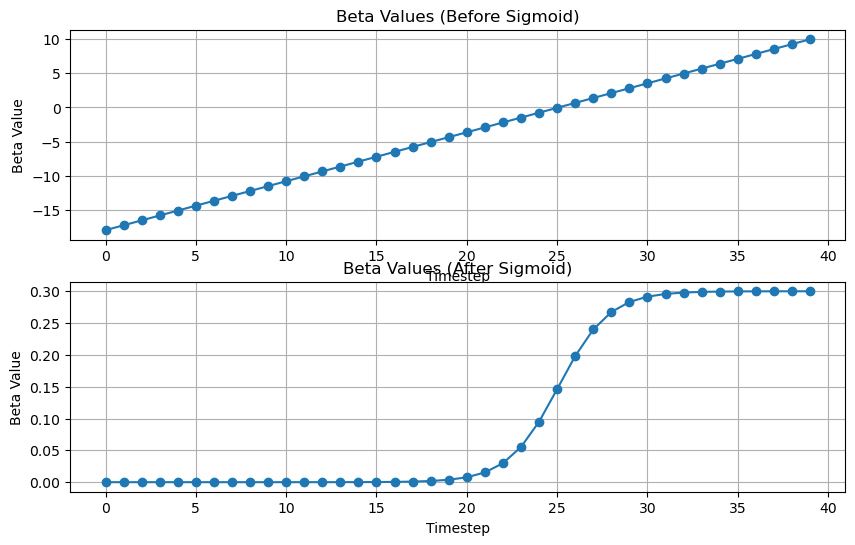

In [58]:
n_steps = 40
# so apparently -18 and 10 are hyperparameters
betas = torch.linspace(-18, 10, n_steps) 
print(f'betas: {betas}\n')

# and these scale factors are meant to make the thing positive and small, also hyperparameters
beta = torch.sigmoid(betas) * (3e-1 - 1e-5) + 1e-5 
print(f'beta: {beta.shape}\n{beta}\n')

beta_forward = beta[t]
print(f'beta_forward: {beta_forward.shape}\n{beta_forward}\n')
# i guess the -18 and 10 mean that the sigmoid is more towards the right rather than being centered

plt.figure(figsize=(10, 6))

# Plot betas
plt.subplot(2, 1, 1)
plt.plot(range(n_steps), betas.numpy(), marker='o')
plt.xlabel('Timestep')
plt.ylabel('Beta Value')
plt.title('Beta Values (Before Sigmoid)')
plt.grid(True)

# Plot beta
plt.subplot(2, 1, 2)
plt.plot(range(n_steps), beta.numpy(), marker='o')
plt.xlabel('Timestep')
plt.ylabel('Beta Value')
plt.title('Beta Values (After Sigmoid)')
plt.grid(True)

# Highlight beta_forward
plt.plot(t.item(), torch.to_numpy(beta_forward.cpu()).item(), marker='o', color='red', markersize=10)
plt.annotate(f'beta_forward = {beta_forward.item():.4f}', (t.item(), beta_forward.item()),
             xytext=(5, 5), textcoords='offset points', color='red')

plt.tight_layout()
plt.show()

alpha: torch.Size([40])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 0.9998, 0.9995, 0.9991,
        0.9981, 0.9962, 0.9923, 0.9847, 0.9702, 0.9447, 0.9050, 0.8538, 0.8018,
        0.7601, 0.7327, 0.7169, 0.7085, 0.7042, 0.7021, 0.7010, 0.7005, 0.7002,
        0.7001, 0.7001, 0.7000, 0.7000])

alpha_forward: torch.Size([])
0.9846831560134888



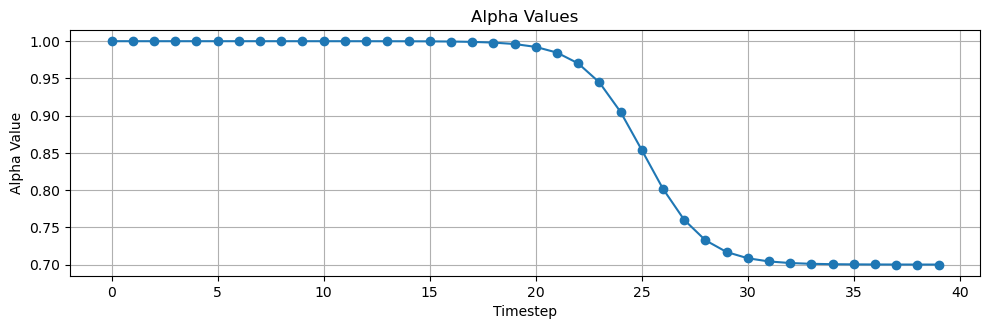

In [61]:
alpha = 1. - beta
print(f'alpha: {alpha.shape}\n{alpha}\n')

alpha_forward = alpha[t]
print(f'alpha_forward: {alpha_forward.shape}\n{alpha_forward}\n')

plt.figure(figsize=(10, 6))

# Plot beta
plt.subplot(2, 1, 2)
plt.plot(range(n_steps), alpha.numpy(), marker='o')
plt.xlabel('Timestep')
plt.ylabel('Alpha Value')
plt.title('Alpha Values')
plt.grid(True)

plt.tight_layout()
plt.show()

alpha_bar: torch.Size([40])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999,
        0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9996, 0.9994, 0.9990, 0.9980,
        0.9962, 0.9924, 0.9848, 0.9697, 0.9408, 0.8888, 0.8043, 0.6868, 0.5506,
        0.4185, 0.3066, 0.2198, 0.1557, 0.1097, 0.0770, 0.0540, 0.0378, 0.0265,
        0.0185, 0.0130, 0.0091, 0.0064])

alpha_cum_forward: torch.Size([])
0.9696906805038452



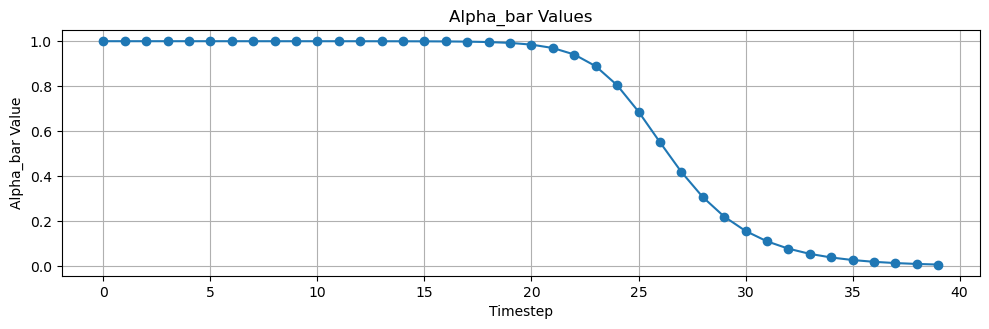

In [64]:
alpha_bar = torch.cumprod(alpha, dim=0)
print(f'alpha_bar: {alpha_bar.shape}\n{alpha_bar}\n')

alpha_cum_forward = alpha_bar[t]
print(f'alpha_cum_forward: {alpha_cum_forward.shape}\n{alpha_cum_forward}\n')

plt.figure(figsize=(10, 6))

# Plot beta
plt.subplot(2, 1, 2)
plt.plot(range(n_steps), alpha_bar.numpy(), marker='o')
plt.xlabel('Timestep')
plt.ylabel('Alpha_bar Value')
plt.title('Alpha_bar Values')
plt.grid(True)

plt.tight_layout()
plt.show()

x0_scaled: torch.Size([5000, 2])
tensor([[ 0.3708,  1.3137],
        [ 0.7695, -0.8608],
        [ 0.5363,  0.4258],
        ...,
        [ 0.4654,  0.5256],
        [ 0.3706,  0.6175],
        [-0.9050, -0.3267]])



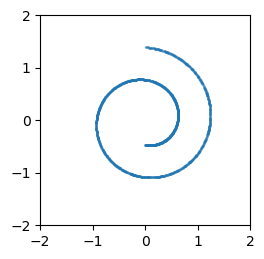

In [68]:
x0_scaled = x0 * torch.sqrt(alpha_cum_forward) 
print(f'x0_scaled: {x0_scaled.shape}\n{x0_scaled}\n')

plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.scatter(x0_scaled[:, 0], x0_scaled[:, 1], alpha=.1, s=1)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.gca().set_aspect('equal')

plt.show()
plt.close()

r: torch.Size([5000, 2])
tensor([[-0.0394,  0.1002],
        [-0.2610,  0.1179],
        [-0.2248,  0.1960],
        ...,
        [-0.2109, -0.1250],
        [ 0.0751,  0.0032],
        [-0.0163, -0.1086]])



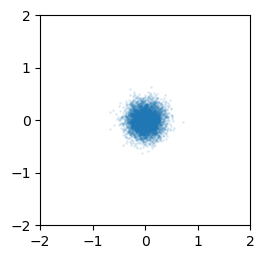

In [69]:
r = torch.randn_like(x0) * torch.sqrt(1. - alpha_cum_forward)
print(f'r: {r.shape}\n{r}\n')

plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.scatter(r[:, 0], r[:, 1], alpha=.1, s=1)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.gca().set_aspect('equal')

plt.show()
plt.close()

xt: torch.Size([5000, 2])
tensor([[ 0.3314,  1.4140],
        [ 0.5085, -0.7429],
        [ 0.3115,  0.6218],
        ...,
        [ 0.2545,  0.4005],
        [ 0.4458,  0.6207],
        [-0.9213, -0.4353]])



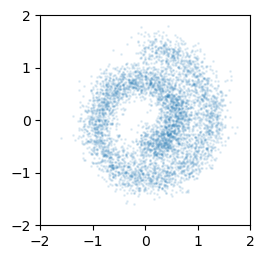

In [70]:
xt = x0_scaled + r
print(f'xt: {xt.shape}\n{xt}\n')

plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.scatter(xt[:, 0], xt[:, 1], alpha=.1, s=1)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.gca().set_aspect('equal')

plt.show()
plt.close()

# ---------- BOOKMARK ------------

In [80]:
mu1_scl = torch.sqrt(alpha_cum_forward / alpha_forward)
print(f'mu1_scl: {mu1_scl.shape}\n{mu1_scl}\n')

mu2_scl = 1. / torch.sqrt(alpha_forward)
print(f'mu2_scl: {mu2_scl.shape}\n{mu2_scl}\n')

cov1 = 1. - alpha_cum_forward / alpha_forward
print(f'cov1: {cov1.shape}\n{cov1}\n')

cov2 = beta_forward / alpha_forward
print(f'cov2: {cov2.shape}\n{cov2}\n')

lam = 1. / cov1 + 1. / cov2
print(f'lam: {lam.shape}\n{lam}\n')

sigma_posterior = torch.sqrt(1. / lam)
print(f'sigma_posterior: {sigma_posterior.shape}\n{sigma_posterior}\n')

mu1_scl: torch.Size([])
0.9923579692840576

mu2_scl: torch.Size([])
1.0077475309371948

cov1: torch.Size([])
0.015225708484649658

cov2: torch.Size([])
0.01555508654564619

lam: torch.Size([])
129.96603393554688

sigma_posterior: torch.Size([])
0.08771726489067078



mu_posterior: torch.Size([5000, 2])
tensor([[ 0.3540,  1.3739],
        [ 0.6454, -0.8087],
        [ 0.4284,  0.5268],
        ...,
        [ 0.3639,  0.4673],
        [ 0.4109,  0.6239],
        [-0.9202, -0.3834]])



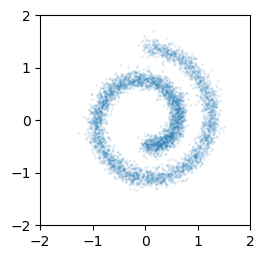

In [81]:
mu_posterior = (x0 * mu1_scl / cov1 + xt * mu2_scl / cov2) / lam
print(f'mu_posterior: {mu_posterior.shape}\n{mu_posterior}\n')

plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.scatter(mu[:, 0], mu[:, 1], alpha=.1, s=1)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.gca().set_aspect('equal')

plt.show()
plt.close()

that ends the forward pass. now gotta to the reverse to get the counterparts to mu_posterior and sigma_posterior, mu and sigma, which is the part that actually uses the model

model_out: torch.Size([5000, 4])
tensor([[-0.0791, -0.0402, -0.0079,  0.0600],
        [-0.0589,  0.0430, -0.0119,  0.0199],
        [-0.0668, -0.0191,  0.0065,  0.0415],
        ...,
        [-0.0672, -0.0078,  0.0105,  0.0367],
        [-0.0693, -0.0206,  0.0082,  0.0453],
        [-0.0753,  0.0097, -0.0249, -0.0007]], grad_fn=<AddmmBackward0>)

mu: torch.Size([5000, 2])
tensor([[-0.0791, -0.0402],
        [-0.0589,  0.0430],
        [-0.0668, -0.0191],
        ...,
        [-0.0672, -0.0078],
        [-0.0693, -0.0206],
        [-0.0753,  0.0097]], grad_fn=<SplitBackward0>)



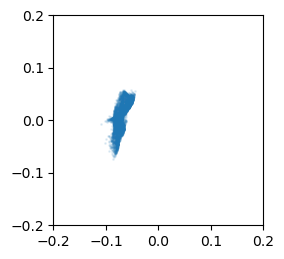

h: torch.Size([5000, 2])
tensor([[-0.0079,  0.0600],
        [-0.0119,  0.0199],
        [ 0.0065,  0.0415],
        ...,
        [ 0.0105,  0.0367],
        [ 0.0082,  0.0453],
        [-0.0249, -0.0007]], grad_fn=<SplitBackward0>)



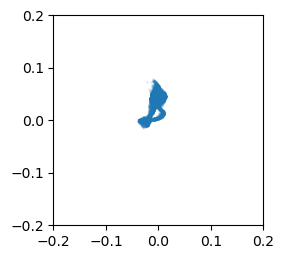

In [90]:
device = 'cpu'
model_mlp = MLP(hidden_dim=128).to(device)
model_out = model_mlp(xt, t)
print(f'model_out: {model_out.shape}\n{model_out}\n')

mu, h = model_out.chunk(2, dim=1)

print(f'mu: {mu.shape}\n{mu}\n')
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.scatter(mu.detach().numpy()[:, 0], mu.detach().numpy()[:, 1], alpha=.1, s=1)
plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])
plt.gca().set_aspect('equal')
plt.show()
plt.close()

print(f'h: {h.shape}\n{h}\n')
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.scatter(h.detach().numpy()[:, 0], h.detach().numpy()[:, 1], alpha=.1, s=1)
plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])
plt.gca().set_aspect('equal')
plt.show()
plt.close()

# so the model simultaneously creates both of these things, the mu and the h. i guess h will get turned into sigma? 

sigma: torch.Size([5000, 2])
tensor([[0.9960, 1.0305],
        [0.9941, 1.0100],
        [1.0032, 1.0209],
        ...,
        [1.0052, 1.0185],
        [1.0041, 1.0229],
        [0.9876, 0.9996]], grad_fn=<SqrtBackward0>)



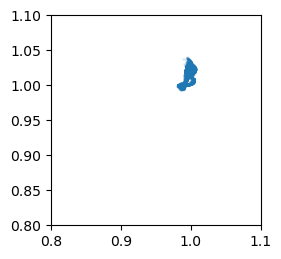

In [91]:
sigma = torch.sqrt(torch.exp(h))
print(f'sigma: {sigma.shape}\n{sigma}\n')
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.scatter(sigma.detach().numpy()[:, 0], sigma.detach().numpy()[:, 1], alpha=.1, s=1)
plt.xlim([0.8, 1.1])
plt.ylim([0.8, 1.1])
plt.gca().set_aspect('equal')
plt.show()
plt.close()

samples: torch.Size([5000, 2])
tensor([[-0.9984,  1.3829],
        [-0.0068,  0.2412],
        [ 1.2902, -0.2012],
        ...,
        [-0.3036,  0.8966],
        [-2.4439, -0.4388],
        [-1.0826, -0.6165]], grad_fn=<AddBackward0>)



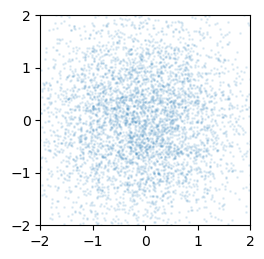

In [94]:
samples = mu + torch.randn_like(xt) * sigma
print(f'samples: {samples.shape}\n{samples}\n')
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.scatter(samples.detach().numpy()[:, 0], samples.detach().numpy()[:, 1], alpha=.1, s=1)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.gca().set_aspect('equal')
plt.show()
plt.close()

some_sort_of_scale: torch.Size([5000, 2])
tensor([[-0.4016,  0.4451],
        [-0.2451, -0.1407],
        [-0.3744, -0.3534],
        ...,
        [-0.4042, -0.3875],
        [-0.3818, -0.2979],
        [-0.1301, -0.4188]], grad_fn=<SubBackward0>)



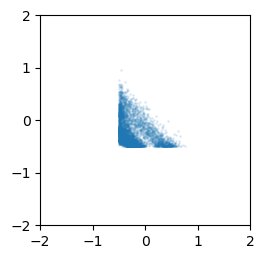

In [96]:
some_sort_of_scale = (sigma_posterior ** 2 + (mu_posterior - mu) ** 2) / (2 * sigma ** 2) - 0.5
print(f'some_sort_of_scale: {some_sort_of_scale.shape}\n{some_sort_of_scale}\n')
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.scatter(some_sort_of_scale.detach().numpy()[:, 0], some_sort_of_scale.detach().numpy()[:, 1], alpha=.1, s=1)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.gca().set_aspect('equal')
plt.show()
plt.close()

In [97]:
KL = torch.log(sigma) - torch.log(sigma_posterior) + some_sort_of_scale
loss = KL.mean()
print(loss)

tensor(2.1967, grad_fn=<MeanBackward0>)


ok so that's training. the forward function takes the real data and scrambles it. then the reverse actually runs the model. the forward function creates these two objects mu_posterior and sigma_posterior that the reverse has to approximate. 

ok now how does inference work? of course we start off with some random noise

In [105]:
noise = torch.randn((5000, 2))
print(f'noise: {noise.shape}\n{noise}\n')

noise: torch.Size([5000, 2])
tensor([[ 0.0896,  0.2053],
        [-0.3998,  1.1971],
        [-0.7590, -0.6527],
        ...,
        [-0.1636, -0.9783],
        [-1.6389,  0.6123],
        [ 0.0155,  0.0765]])



In [106]:
# and then we end up keeping track of the noise over the course of the entire process for some reason
samples = [noise]

In [108]:
for t in range(n_steps):
    _, _, x = model.reverse(samples[-1], n_steps - t - 1 + 1)
    samples.append(x)

RuntimeError: Placeholder storage has not been allocated on MPS device!

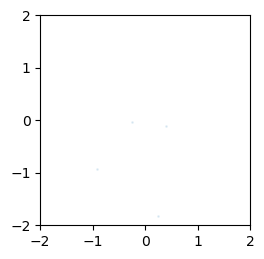

In [103]:
output = samples[-1]
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.scatter(output.detach().numpy()[:, 0], output.detach().numpy()[:, 1], alpha=.1, s=1)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.gca().set_aspect('equal')
plt.show()
plt.close()

In [104]:
output

tensor([[-0.9225, -0.9258],
        [-0.2574, -0.0263],
        [ 0.3969, -0.1008],
        [ 0.2480, -1.8292]])